<font color='red'>_Note that this Notebook has been ran before removing outliers from the data._</font>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../")

import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from itertools import product
import matplotlib.pyplot as plt

from src.utils.eye_tracking_data import (
    get_eye_tracking_data,
    with_media_type_column,
    with_time_since_start_column,
)
from src.utils.saliency import get_kde_density

## Loading Processed Data

In [3]:
data = get_eye_tracking_data()
data = with_media_type_column(data)
data = with_time_since_start_column(data)
data.head()

,ExperimentId,SessionId,ParticipantId,SequenceId,SetId,X_sc,Y_sc,X_px,Y_px,Timestamp_ns,MediaType,TimeSinceStart_ns
0,1,1,1,1,1,0.813762,0.661315,4999.7515,2031.5590,8492802345543344252,Image,0
1,1,1,1,1,1,0.739250,0.870603,4541.9500,2674.4930,8492802345801721952,Image,258377700
2,1,1,1,1,1,0.680598,0.649704,4181.5950,1995.8899,8492802345847617152,Image,304272900
3,1,1,1,1,1,0.663174,0.657053,4074.5400,2018.4670,8492802345951811152,Image,408466900
4,1,1,1,1,1,0.548628,0.777003,3370.7708,2386.9520,8492802346058247252,Image,514903000


In [4]:
interpolated_data = get_eye_tracking_data(interpolated=True)
interpolated_data = with_media_type_column(interpolated_data)
interpolated_data = with_time_since_start_column(interpolated_data)
interpolated_data.head()

,ExperimentId,SessionId,ParticipantId,SequenceId,SetId,X_sc,Y_sc,X_px,Y_px,Timestamp_ns,MediaType,TimeSinceStart_ns
0,1,1,1,1,1,0.813762,0.661315,4999.7515,2031.5590,8492802345500000000,Image,0
1,1,1,1,1,1,0.796455,0.677788,4893.4220,2082.1643,8492802345550000000,Image,50000000
2,1,1,1,1,1,0.779149,0.694261,4787.0920,2132.7698,8492802345600000000,Image,100000000
3,1,1,1,1,1,0.761843,0.710734,4680.7617,2183.3752,8492802345650000000,Image,150000000
4,1,1,1,1,1,0.744536,0.727207,4574.4320,2233.9805,8492802345700000000,Image,200000000


In [5]:
fixation_data = get_eye_tracking_data(fixation=True)
fixation_data = with_media_type_column(fixation_data)
fixation_data = with_time_since_start_column(fixation_data)
fixation_data.head()

,ExperimentId,SessionId,ParticipantId,SequenceId,SetId,X_sc,Y_sc,X_px,Y_px,StartTimestamp_ns,EndTimestamp_ns,Duration_ns,MediaType,TimeSinceStart_ns
0,1,1,1,1,1,0.456977,0.742343,2807.6680,2280.4790,8492802347900000000,8492802348150000000,250000000,Image,0
1,1,1,1,1,1,0.558270,0.973386,3430.0080,2990.2402,8492802348150000000,8492802348450000000,300000000,Image,250000000
2,1,1,1,1,1,0.862491,0.557093,5299.1445,1711.3899,8492802349250000000,8492802349500000000,250000000,Image,1350000000
3,1,1,1,1,1,0.883241,0.562619,5426.6310,1728.3650,8492802349500000000,8492802349750000000,250000000,Image,1600000000
4,1,1,1,1,1,0.772883,0.622203,4748.5930,1911.4080,8492802350350000000,8492802350600000000,250000000,Image,2450000000


## Outlier Detection using KDE Maps

In [6]:
def get_kde_score_map_loss(
    kde_score_map1: np.ndarray,
    kde_score_map2: np.ndarray,
) -> float:
    """
    Get the KDE log score map loss, as the Mean Squared Error between two KDE log score maps.
    Args:
        kde_score_map1 (np.ndarray): The first KDE log score map.
        kde_score_map2 (np.ndarray): The second KDE log score map.
        saliency_width (int): The width of the saliency map.
        saliency_height (int): The height of the saliency map.
        bandwidth (float): The bandwidth of the KDE.

    Returns:
        float: The KDE log score map loss.
    """
    kde_score_map_loss = np.mean((kde_score_map1 - kde_score_map2) ** 2)

    return kde_score_map_loss


def plot_kde_session_score_map_losses(
    data: pd.DataFrame,
    saliency_width: int,
    saliency_height: int,
    bandwidth: float,
    n_samples: int = 10000,
) -> None:
    """
    Plot the KDE score map losses for each session.

    Args:
        data (pd.DataFrame): The eye tracking data.
        saliency_width (int): The width of the saliency map.
        saliency_height (int): The height of the saliency map.
        bandwidth (float): The bandwidth of the KDE.
        n_samples (int): The number of samples to use for KDE computation.
    """
    # Compute the KDE score maps
    kde_score_maps = {}

    for experiment_id, session_id in product([1, 2], [1, 2]):
        filtered_data = data[
            (data["ExperimentId"] == experiment_id) & (data["SessionId"] == session_id)
        ]
        participant_ids = filtered_data["ParticipantId"].unique()
        for participant_id in tqdm(
            participant_ids, desc="⌛ Computing KDE score maps..."
        ):
            participant_data = filtered_data[
                filtered_data["ParticipantId"] == participant_id
            ]
            coordinates = participant_data[["X_sc", "Y_sc"]].values
            if n_samples > 0:
                coordinates = coordinates[
                    np.random.choice(coordinates.shape[0], n_samples)
                ]
            coordinates = np.array(
                [
                    [int(coord[0] * saliency_width), int(coord[1] * saliency_height)]
                    for coord in coordinates
                ]
            )
            kde_density = get_kde_density(
                coordinates=coordinates,
                saliency_width=saliency_width,
                saliency_height=saliency_height,
                kde_bandwidth=bandwidth,
                apply_exponential=True,
            )
            kde_score_maps[(experiment_id, session_id, participant_id)] = kde_density

    # Plot the matrix of KDE score map losses
    for experiment_id, session_id in product([1, 2], [1, 2]):
        filtered_data = data[
            (data["ExperimentId"] == experiment_id) & (data["SessionId"] == session_id)
        ]
        participant_ids = filtered_data["ParticipantId"].unique()
        kde_score_map_losses = np.zeros((len(participant_ids), len(participant_ids)))
        for i, participant_id1 in tqdm(
            enumerate(participant_ids), desc="⌛ Computing KDE score map losses..."
        ):
            for j, participant_id2 in enumerate(participant_ids):
                if i >= j:
                    continue  # Only compute the upper triangle
                kde_score_map_loss = get_kde_score_map_loss(
                    kde_score_maps[(experiment_id, session_id, participant_id1)],
                    kde_score_maps[(experiment_id, session_id, participant_id2)],
                )
                kde_score_map_losses[i, j] = kde_score_map_loss
                kde_score_map_losses[j, i] = kde_score_map_loss

        plt.figure(figsize=(10, 8))
        sns.heatmap(
            kde_score_map_losses,
            xticklabels=participant_ids,
            yticklabels=participant_ids,
            cmap="viridis",
        )
        plt.xlabel("Participant ID")
        plt.ylabel("Participant ID")
        plt.title(
            f"KDE score map losses for Experiment {experiment_id} Session {session_id}"
        )
        plt.tight_layout()
        plt.show()


def plot_kde_set_score_map_losses(
    data: pd.DataFrame,
    saliency_width: int,
    saliency_height: int,
    bandwidth: float,
    n_samples: int = 10000,
) -> None:
    """
    Plot the KDE score map losses for each set.
    
    Args:
        data (pd.DataFrame): The eye tracking data.
        saliency_width (int): The width of the saliency map.
        saliency_height (int): The height of the saliency map.
        bandwidth (float): The bandwidth of the KDE.
        n_samples (int): The number of samples to use for KDE computation.
    """
    # Compute the KDE score maps
    kde_score_maps = {}

    for experiment_id, set_id in product([1, 2], [0, 1]):
        filtered_data = data[
            (data["ExperimentId"] == experiment_id) & (data["SetId"] == set_id)
        ]
        participant_ids = filtered_data["ParticipantId"].unique()
        for participant_id in tqdm(
            participant_ids, desc="⌛ Computing KDE score maps..."
        ):
            participant_data = filtered_data[
                filtered_data["ParticipantId"] == participant_id
            ]
            coordinates = participant_data[["X_sc", "Y_sc"]].values
            if n_samples > 0:
                coordinates = coordinates[
                    np.random.choice(coordinates.shape[0], n_samples)
                ]
            coordinates = np.array(
                [
                    [int(coord[0] * saliency_width), int(coord[1] * saliency_height)]
                    for coord in coordinates
                ]
            )
            kde_density = get_kde_density(
                coordinates=coordinates,
                saliency_width=saliency_width,
                saliency_height=saliency_height,
                kde_bandwidth=bandwidth,
                apply_exponential=True,
            )
            kde_score_maps[(experiment_id, set_id, participant_id)] = kde_density

    # Plot the matrix of KDE score map losses
    for experiment_id, set_id in tqdm(
        product([1, 2], [0, 1]), desc="⌛ Plotting KDE score map losses..."
    ):
        filtered_data = data[
            (data["ExperimentId"] == experiment_id) & (data["SetId"] == set_id)
        ]
        participant_ids = filtered_data["ParticipantId"].unique()
        kde_score_map_losses = np.zeros((len(participant_ids), len(participant_ids)))
        for i, participant_id1 in enumerate(participant_ids):
            for j, participant_id2 in enumerate(participant_ids):
                if i >= j:
                    continue  # Only compute the upper triangle
                kde_score_map_loss = get_kde_score_map_loss(
                    kde_score_maps[(experiment_id, set_id, participant_id1)],
                    kde_score_maps[(experiment_id, set_id, participant_id2)],
                )
                kde_score_map_losses[i, j] = kde_score_map_loss
                kde_score_map_losses[j, i] = kde_score_map_loss

        plt.figure(figsize=(10, 8))
        sns.heatmap(
            kde_score_map_losses,
            xticklabels=participant_ids,
            yticklabels=participant_ids,
            cmap="viridis",
        )
        plt.xlabel("Participant ID")
        plt.ylabel("Participant ID")
        plt.title(f"KDE score map losses for Experiment {experiment_id} Set {set_id}")
        plt.tight_layout()
        plt.show()

In [ ]:
plot_kde_session_score_map_losses(data, 50, 50, 1, 0)
plot_kde_set_score_map_losses(data, 50, 50, 1, 0)

⌛ Computing KDE score maps...: 100%|██████████| 42/42 [02:21<00:00,  3.37s/it]
⌛ Computing KDE score map losses...: 42it [00:00, 3230.65it/s]


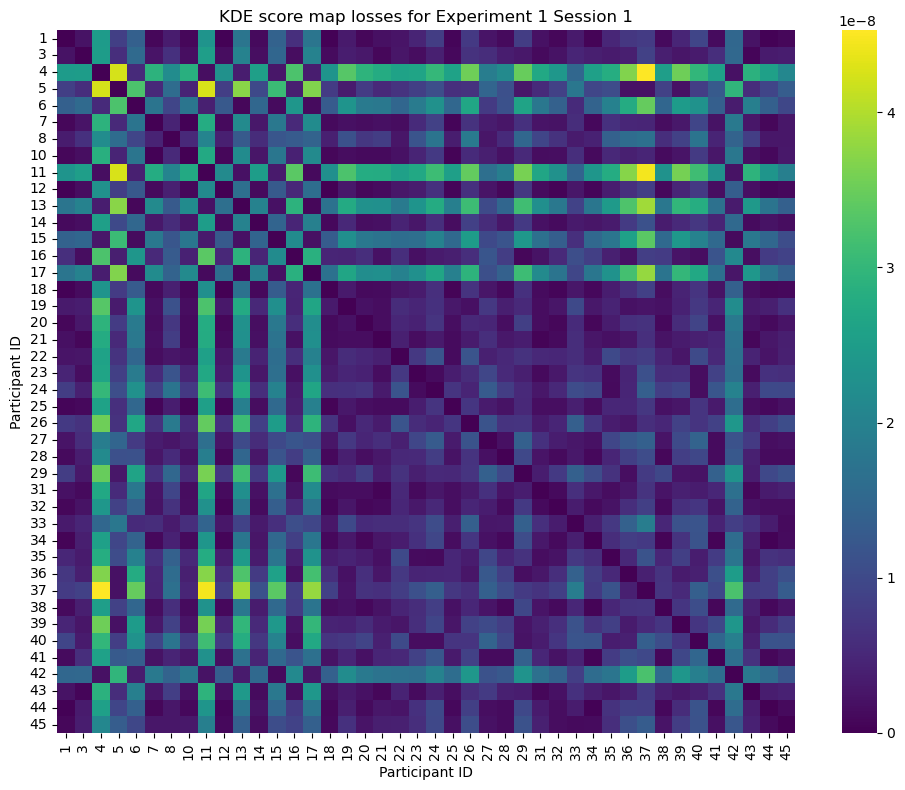

⌛ Computing KDE score map losses...: 43it [00:00, 2863.82it/s]


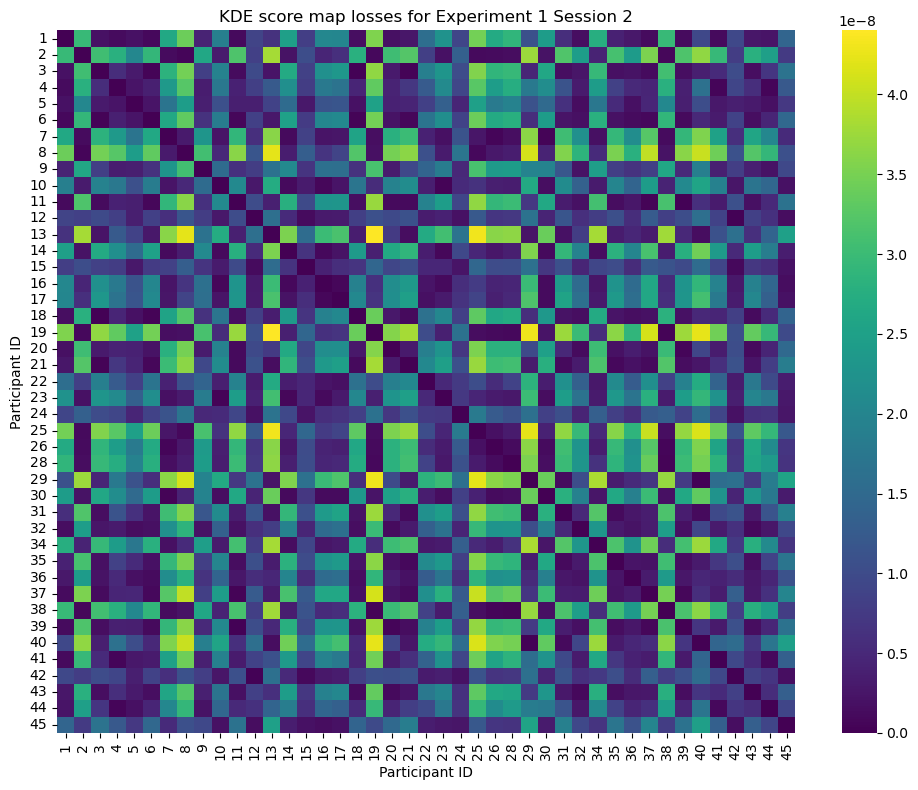

⌛ Computing KDE score map losses...: 41it [00:00, 3048.51it/s]


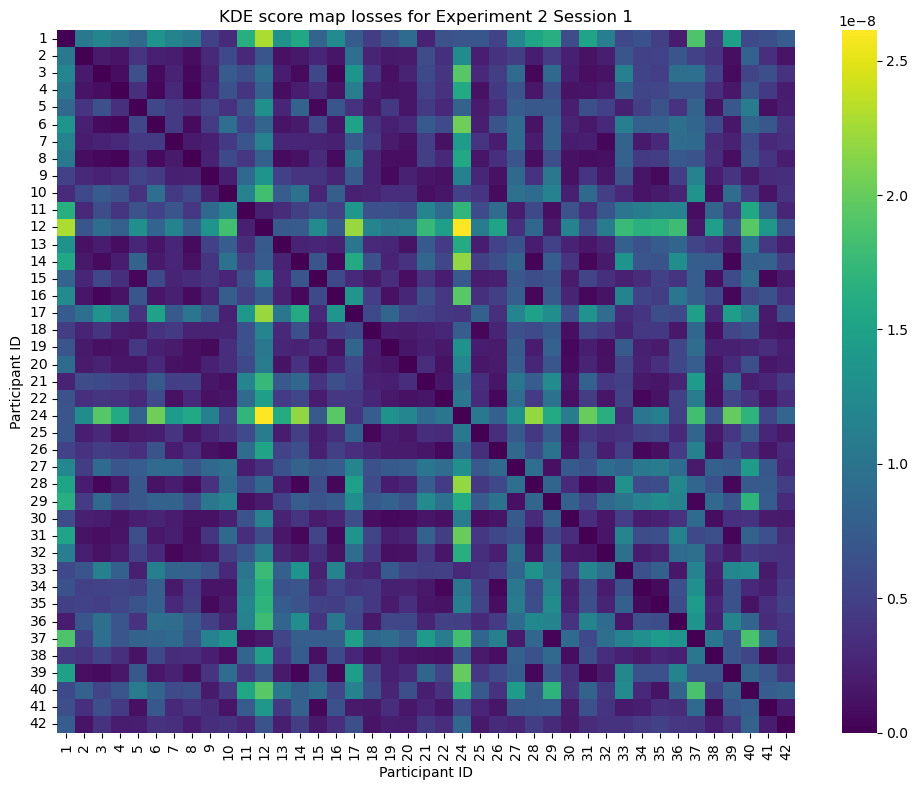

⌛ Computing KDE score map losses...: 42it [00:00, 3085.24it/s]


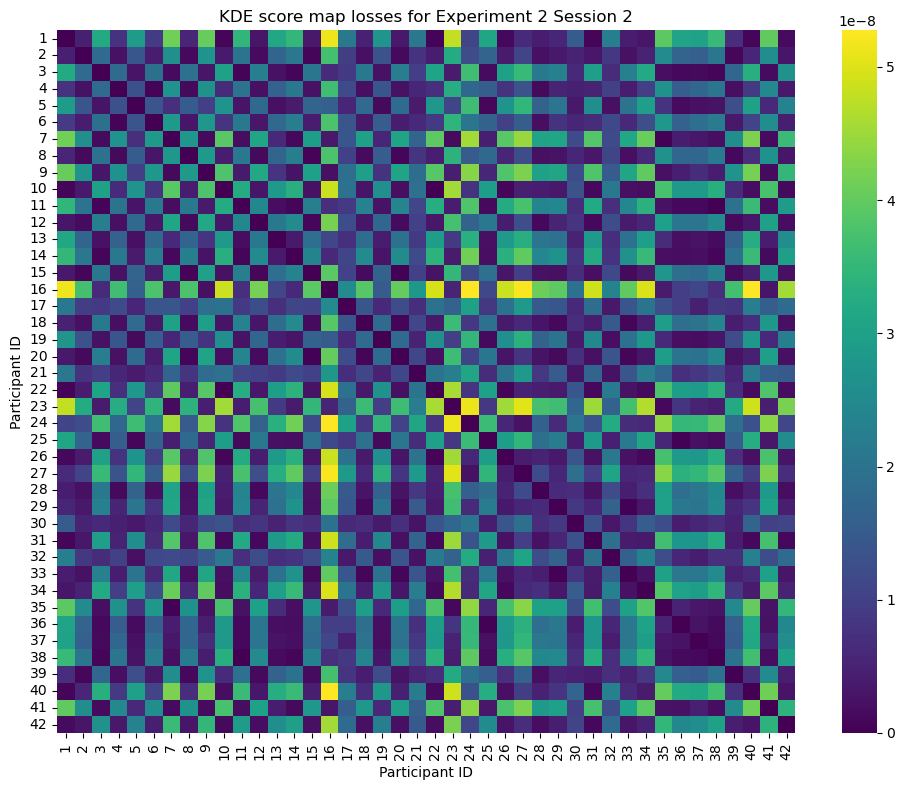

⌛ Computing KDE score maps...: 100%|██████████| 42/42 [02:20<00:00,  3.34s/it]
⌛ Plotting KDE score map losses...: 0it [00:00, ?it/s]

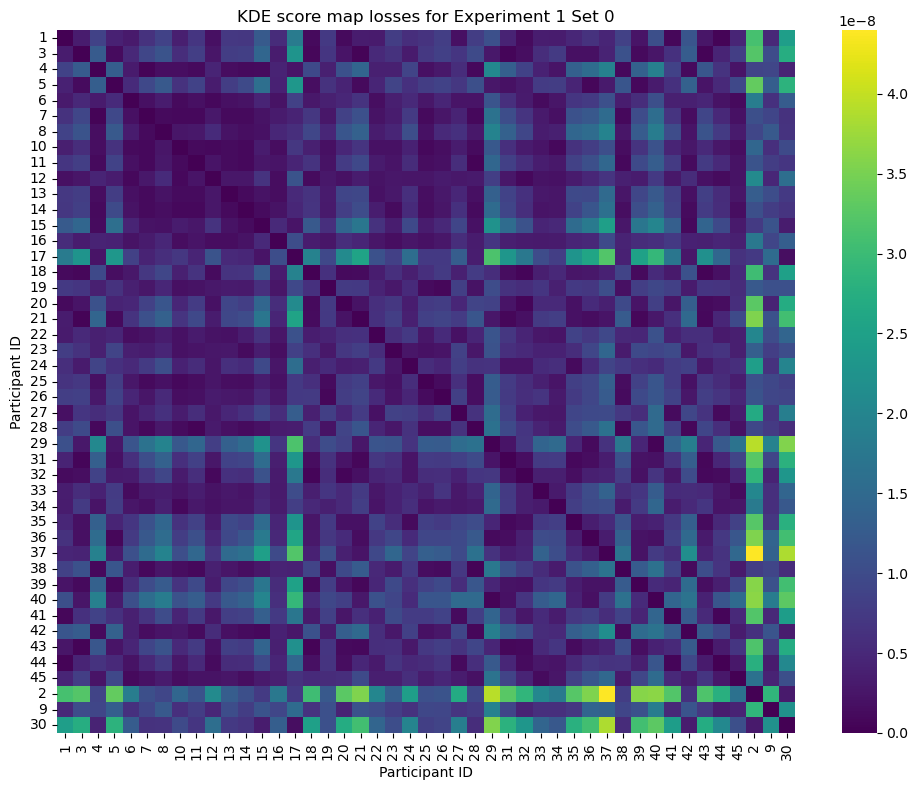

⌛ Plotting KDE score map losses...: 1it [00:00,  2.40it/s]

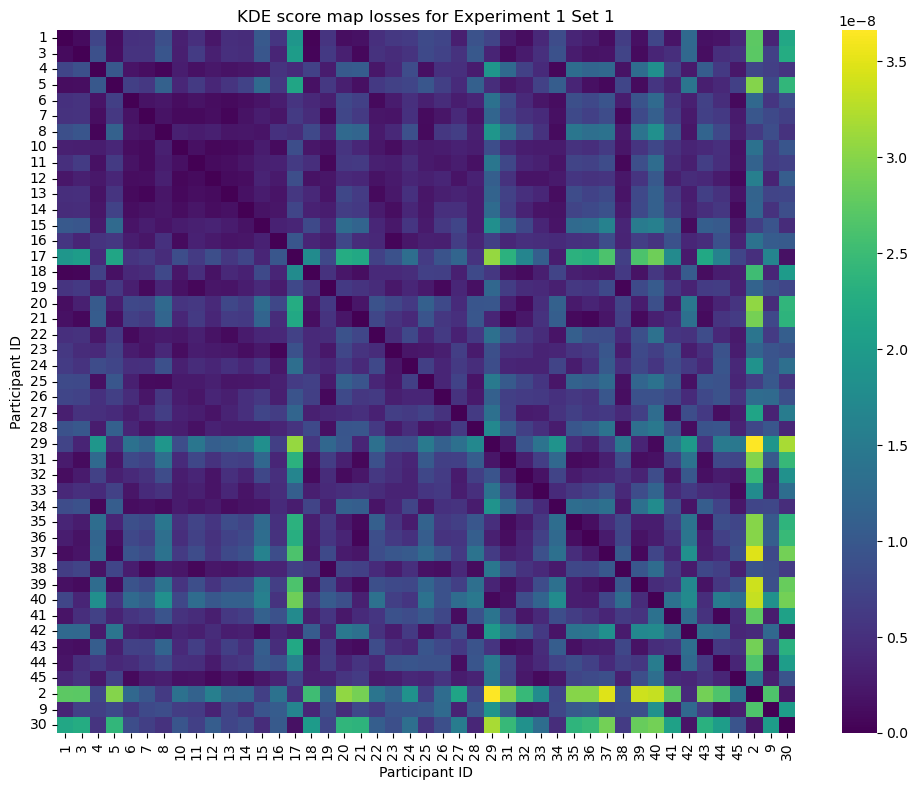

⌛ Plotting KDE score map losses...: 2it [00:00,  2.53it/s]

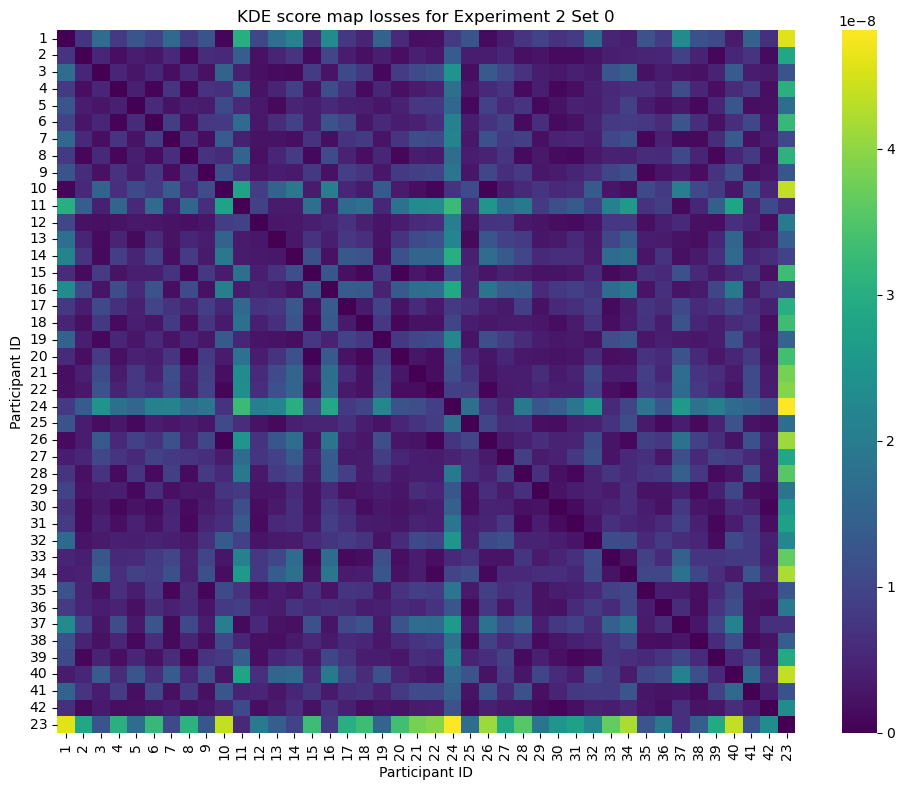

⌛ Plotting KDE score map losses...: 3it [00:01,  2.76it/s]

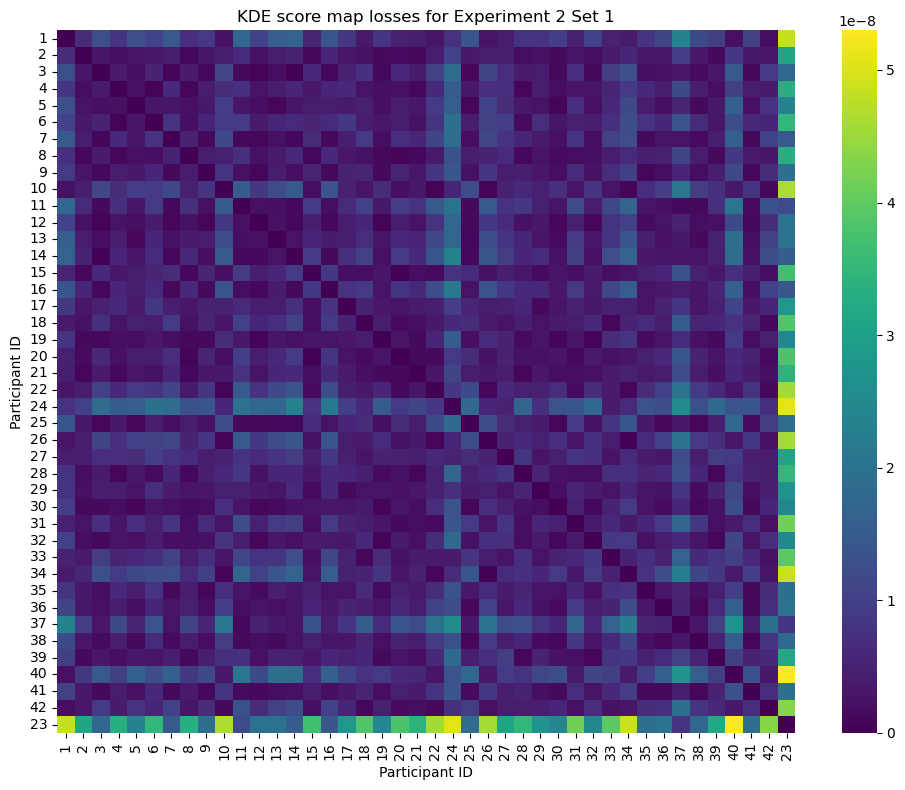

⌛ Plotting KDE score map losses...: 4it [00:01,  2.79it/s]


In [9]:
plot_kde_session_score_map_losses(interpolated_data, 100, 100, 10)
plot_kde_set_score_map_losses(interpolated_data, 100, 100, 10)

In [8]:
plot_kde_session_score_map_losses(fixation_data, 100, 100, 10)
plot_kde_set_score_map_losses(fixation_data, 100, 100, 10)

⌛ Computing KDE score maps...:   5%|▍         | 2/42 [00:09<03:16,  4.92s/it]


KeyboardInterrupt: 